# Codec

We're going to see if FSQ is a good fit for finding the tokens we need for our model. Basing ourselves on the work of Hertz-dev: https://github.com/Standard-Intelligence/hertz-dev/blob/main/tokenizer.py

In [8]:
import jax
import equinox as eqx
import equinox.nn as nn
import jax.numpy as jnp

class ResUnit(eqx.Module):
    conv1: jax.Array
    conv2: jax.Array
    
    def __init__(self, channel_in, channel_out, kernel_size, dilation, bias=True, key=None):
        key1, key2 = jax.random.split(key)
        
        self.conv1 = nn.WeightNorm(nn.Conv1d(channel_in, channel_out, kernel_size, stride=1, dilation=dilation, padding="SAME", use_bias=bias, key=key1))
        self.conv2 = nn.WeightNorm(nn.Conv1d(channel_out, channel_out, kernel_size=1, stride=1,use_bias=bias, padding="SAME",key=key2))

    @eqx.filter_jit
    def __call__(self, x):
        y = self.conv1(jax.nn.elu(x))
        y = self.conv2(jax.nn.elu(y))
        return y + x
    
class Upsample(eqx.Module):
    scale_factor:int
    mode:str
    
    def __init__(self, scale_factor, mode):
        self.scale_factor = scale_factor
        self.mode = mode
    
    @eqx.filter_jit
    def __call__(self, x):
        new_height = x.shape[1] * self.scale_factor
        return jax.image.resize(x, (x.shape[0], new_height), method=self.mode)
    
class ResBlock(eqx.Module):
    suite: nn.Sequential

    def __init__(self, channel_in, channel_out, kernel_size:int,stride:int, mode:str, dilations=(1, 3, 9), bias=True, key=None):
        key1, key2 = jax.random.split(key)

        res_channels = channel_in if mode == 'encoder' else channel_out
        
        res_units = [
                    ResUnit(res_channels, res_channels, kernel_size=kernel_size, bias=False, dilation=dilation, key=k) for dilation, k in zip(dilations, jax.random.split(key1, len(dilations)))
                ]

        if mode == "encoder":
            if channel_in == channel_out:
                self.suite = nn.Sequential(res_units + [
                    nn.AvgPool1d(kernel_size=stride, stride=stride),
                ])
            else:
                self.suite = nn.Sequential(res_units + [
                    nn.WeightNorm(nn.Conv1d(channel_in, channel_out, kernel_size=(2*stride), stride=stride, use_bias=bias, padding="SAME", key=key2))
                ])
        elif mode == "decoder":
            if channel_in == channel_out:
                self.suite = nn.Sequential([
                    Upsample(scale_factor=stride, mode="nearest"),
                ]+ res_units)
            else:
                self.suite = nn.Sequential([
                    nn.WeightNorm(nn.ConvTranspose1d(channel_in, channel_out, kernel_size=(2*stride), stride=stride, use_bias=bias, padding="SAME", key=key2))
                ] + res_units)
                
    @eqx.filter_jit
    def __call__(self, x):
        out = x
        for unit in self.suite:
            out = unit(out)
        return out

class Encoder(eqx.Module):
    suite: list
    
    def __init__(self, in_channels, hidden_channels, latent_channels, kernel_size=5, channel_ratios: tuple =(1,4,8,8,16,16),
                 strides:tuple=(2,2,2,5,5),key=None):
        key0, key1, key2 = jax.random.split(key, 3)
        self.suite = [nn.WeightNorm(nn.Conv1d(
            in_channels,
            hidden_channels * channel_ratios[0],
            kernel_size=kernel_size,
            stride=1,
            padding="SAME",
            use_bias=False,
            key=key0,            
        ))] +[
            ResBlock(
                hidden_channels * channel_ratios[idx],
                hidden_channels * channel_ratios[idx + 1],
                kernel_size=kernel_size,
                stride= strides[idx],
                mode="encoder",
                bias=True,
                key=k,
            ) for idx, k in enumerate(jax.random.split(key1, len(strides)))
        ] +[nn.WeightNorm(nn.Conv1d(
            hidden_channels * channel_ratios[-1], latent_channels, kernel_size=1, padding="SAME", key=key2
        ))]
        
    @eqx.filter_jit
    def __call__(self, x):
        out = x 
        
        for unit in self.suite:
            out = unit(out)
            # jax.debug.print("{x}", x=out[0][:10])
            out = jax.nn.elu(out)

        return out



class Decoder(eqx.Module):
    suite: list
    
    def __init__(self, in_channels, hidden_channels, latent_channels, kernel_size=5, channel_ratios: tuple =(16,16,8,8,4,1),
                 strides:tuple=(5,5,2,2,2),key=None):
        key0, key1, key2 = jax.random.split(key, 3)
        self.suite = [nn.WeightNorm(nn.ConvTranspose1d(
            latent_channels,
            hidden_channels * channel_ratios[0],
            kernel_size=1,
            padding="SAME",
            use_bias=True,
            key=key0,            
        ))] +[
            ResBlock(
                hidden_channels * channel_ratios[idx],
                hidden_channels * channel_ratios[idx + 1],
                kernel_size=kernel_size,
                stride= strides[idx],
                mode="decoder",
                bias=True,
                key=k,
            ) for idx, k in enumerate(jax.random.split(key1, len(strides)))
        ] +[nn.WeightNorm(nn.ConvTranspose1d(
            hidden_channels * channel_ratios[-1], in_channels, kernel_size=kernel_size, stride=1, padding="SAME", key=key2
        ))]
        
    @eqx.filter_jit
    def __call__(self, x):
        out = x 
        for unit in self.suite:
            out = unit(out)
            # jax.debug.print("{x}", x=out[0][:10])
            out = jax.nn.elu(out)

        return out

In [9]:
x = jax.random.normal(key=jax.random.key(1), shape=(1, 16000))
enc = Encoder(1, 4, 1, 5, key=jax.random.key(1))
dec = Decoder(1, 4, 1, 5, key=jax.random.key(1))

y = enc(x)
z = dec(y)

print(x.shape)
print(y.shape)
print(z.shape)

(1, 16000)
(1, 80)
(1, 16000)


We take the code from the google repo for the FSQ.

In [10]:

Codeword = jax.Array
Indices = jax.Array


class FSQ(eqx.Module):
    """Quantizer, taken from https://github.com/google-research/google-research/blob/master/fsq/fsq.ipynb"""

    _levels: list[int]
    _levels_np: jax.Array
    _eps: float
    _basis: jax.Array
    _implicit_codebook: jax.Array

    def __init__(self, levels: list[int], eps: float = 1e-3):
        self._levels = levels
        self._eps = eps
        self._levels_np = jnp.asarray(levels)
        self._basis = jnp.concatenate(
            (jnp.array([1]), jnp.cumprod(self._levels_np[:-1]))
        )

        self._implicit_codebook = self.indexes_to_codes(jnp.arange(self.codebook_size))

    @property
    def num_dimensions(self) -> int:
        """Number of dimensions expected from inputs."""
        return len(self._levels)

    @property
    def codebook_size(self):
        """Size of the codebook."""
        return jnp.prod(jnp.array(self._levels))

    @property
    def codebook(self):
        """Returns the implicit codebook. Shape (prod(levels), num_dimensions)."""
        return self._implicit_codebook

    @eqx.filter_jit
    def round_ste(self, z):
        """Round with straight through gradients."""
        zhat = jnp.round(z)
        return z + jax.lax.stop_gradient(zhat - z)

    @eqx.filter_jit
    def bound(self, z: jax.Array) -> jax.Array:
        """Bound `z`, an array of shape (..., d)."""
        half_l = (self._levels_np - 1) * (1 - self._eps) / 2
        offset = jnp.where(self._levels_np % 2 == 1, 0.0, 0.5)
        shift = jnp.tan(offset / half_l)
        return jnp.tanh(z + shift) * half_l - offset

    @eqx.filter_jit
    def __call__(self, z: jax.Array) -> Codeword:
        """Quanitzes z, returns quantized zhat, same shape as z."""
        quantized = self.round_ste(self.bound(z))

        # Renormalize to [-1, 1].
        half_width = self._levels_np // 2
        return quantized / half_width

    def _scale_and_shift(self, zhat_normalized):
        # Scale and shift to range [0, ..., L-1]
        half_width = self._levels_np // 2
        return (zhat_normalized * half_width) + half_width

    def _scale_and_shift_inverse(self, zhat):
        half_width = self._levels_np // 2
        return (zhat - half_width) / half_width

    def codes_to_indexes(self, zhat: Codeword) -> Indices:
        """Converts a `code` to an index in the codebook."""
        assert zhat.shape[-1] == self.num_dimensions
        zhat = self._scale_and_shift(zhat)
        return (zhat * self._basis).sum(axis=-1).astype(jnp.uint32)

    def indexes_to_codes(self, indices: Indices) -> Codeword:
        """Inverse of `indexes_to_codes`."""
        indices = indices[..., jnp.newaxis]
        codes_non_centered = jnp.mod(
            jnp.floor_divide(indices, self._basis), self._levels_np
        )
        return self._scale_and_shift_inverse(codes_non_centered)


class VQVAE(eqx.Module):
    encoder: Encoder
    decoder: Decoder
    quantizer: FSQ

    def __init__(self, in_channels, hidden_channels, latent_channels, levels, key=None):
        key1, key2 = jax.random.split(key)

        self.encoder = Encoder(in_channels, hidden_channels, latent_channels, key=key1)
        self.decoder = Decoder(in_channels, hidden_channels, latent_channels, key=key2)
        self.quantizer = FSQ(levels=levels)
        print("✅ Model initialized")

    @eqx.filter_jit
    def __call__(self, x):
        
        z_e = self.encoder(x)
        reshaped_z_e = jnp.reshape(z_e, (-1, 5)) #16000 Hz -> 16Hz = 1000 points per code downsampled from 1000 to 5. Map each set of 5 to their respective code and map back. There are 4 levels thus 5 * (2 ** 4) = 80bits per codeword
        reshaped_z_q = self.quantizer(reshaped_z_e)
        z_q = jnp.reshape(reshaped_z_q, z_e.shape)
        y = self.decoder(z_q)
        return y

In [4]:
x = jax.random.normal(key=jax.random.key(0), shape=(1, 16000))
model = VQVAE(1, 4, 1, [4], key=jax.random.key(4))
y = model(x)
print(x.shape)
print(y.shape)
# print(z.shape)

✅ Model initialized
(1, 16000)
(1, 16000)


Let's train it and see what results we get !

✅ Model initialized


/tmp/ipykernel_576588/1167594965.py:73: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  jax.tree_map(reset_params, model)


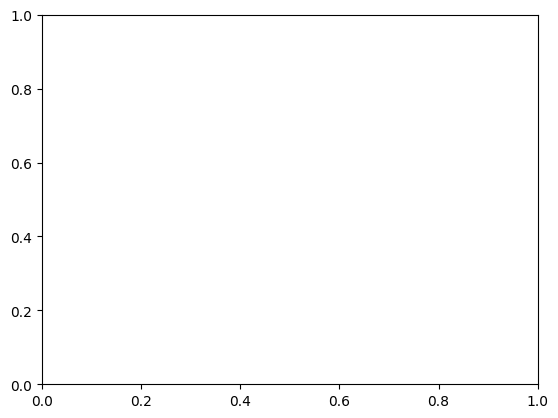

In [13]:
import optax
from tensorboardX import SummaryWriter
from datasets import load_dataset
import datetime
import time

import jax
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import librosa
key1, key2 = jax.random.split(jax.random.key(1), 2)

model = VQVAE(1, 32, 4, [6], key=key1)

optimizer = optax.adam(1e-5)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

writer = SummaryWriter(log_dir='./runs/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

epochs = 50
batch_size = 32
step = 0

dataset = load_dataset("blabble-io/libritts_r", "clean", streaming=True)

def cut_up(samples):
    list = []
    for sample in samples["audio"]:
        resampled = librosa.resample(sample["array"], orig_sr=22050, target_sr=16000)
        for i in range(0, (int(len(resampled)//16000) -1)):
            list.append(resampled[i*16000:i*16000+16000])
    return {"audio": list}

dataset = dataset.map(cut_up, batched=True, remove_columns=['text_normalized', 'text_original', 'speaker_id', 'path', 'chapter_id', 'id'])

dataloader= dataset["train.clean.360"].batch(batch_size=batch_size)


@eqx.filter_jit
@eqx.filter_value_and_grad(has_aux=True)
def calculate_losses(model, x):
    y = jax.vmap(model)(x)
    return jnp.mean(jnp.linalg.norm((x - y), ord=2, axis=(0, 1))), y

@eqx.filter_jit
def make_step(model, optimizer, opt_state, x):
    (total_loss, y), grads = (
        calculate_losses(model, x)
    )
    updates, opt_state = optimizer.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)

    return (
        model,
        opt_state,
        total_loss,
        grads,
        y
    )
    
key = jax.random.key(3)

def reset_params(x):
    global key
    key, grab= jax.random.split(key)
    if hasattr(x, "weight"):
        var = 3.6/(jnp.cumprod(x.weight.shape))
        x.weight = jax.nn.initializers.normal(var)(grab, shape=x.weight.shape)
    return x
        

jax.tree_map(reset_params, model)
    
fig, ax = plt.subplots(1)
# fig.show()
step = 0


In [15]:

for epoch in range(epochs):
    # eqx.tree_serialise_leaves(f"checkpoints/{epoch}.eqx", model)
    for batch in dataloader:
        input = jnp.expand_dims(jnp.array(batch["audio"]), 1)
        model, opt_state, total_loss, grads, y = make_step(model, optimizer, opt_state, input)

        # Log codebook updates to TensorBoard
        writer.add_scalar('Loss/Total', total_loss, step)
        # time.sleep(3)
        step+=1
        if (step // batch_size) % 50 == 0:
            ax.clear()
            ax.plot(batch["audio"][0])
            ax.plot(y[0][0])
            display(fig)
            clear_output(wait=True)
            
    # plt.imshow(y[0])otal_loss}")

KeyboardInterrupt: 

In [ ]:
eqx.tree_serialise_leaves("checkpoints/fsq.eqx", model)

In [ ]:

data = iter(dataloader)

In [18]:
import IPython 

sample = next(data)["audio"][0]
IPython.display.Audio(sample, rate=16000)


In [20]:

y = model(jnp.expand_dims(sample,0))
z = model.encoder(jnp.expand_dims(sample, 0))
codes = model.quantizer.codes_to_indexes(jnp.expand_dims(model.quantizer(z), -1))
print(codes)

IPython.display.Audio(y, rate=16000)

[[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 4 1 4 1 2 2 2 2 2 1 1
  2 4 4 4 4 2 2 5 4 2 2 1 1 2 3 2 3 4 4 3 3 4 4 3 3 4 4 1 2 2 2 2 2 2 2 2
  2 2 3 4 4 4 2 2]
 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 4 3 3 4 4 3 3 3 3 3 4 4
  4 4 4 2 1 1 1 4 5 5 4 4 3 2 1 1 1 2 5 5 5 5 5 4 4 2 1 3 5 2 4 3 3 3 3 3
  4 4 4 4 2 1 1 3]
 [4 3 3 3 4 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 3 4 1 4 2 4 3 4 3 3 3 4 4
  4 4 2 2 2 2 1 1 3 4 3 3 3 3 3 2 1 2 2 3 4 3 2 1 1 1 1 3 3 2 3 3 3 3 4 4
  4 3 2 4 4 3 3 2]
 [2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 2 1 4 1 2 2 1 1 1 1 1 1
  2 4 4 4 4 4 5 2 2 1 1 1 1 3 3 3 4 3 3 2 2 3 3 2 1 1 3 4 1 2 1 1 1 1 1 1
  1 1 1 4 4 2 1 1]]


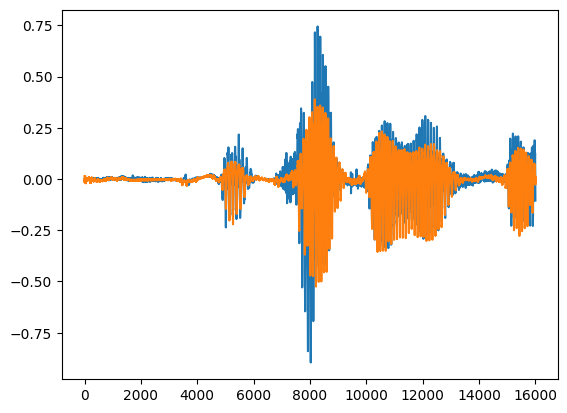

In [23]:
fig, ax = plt.subplots(1)
ax.plot(sample)
ax.plot(y[0])
fig.show()

In [ ]:
eqx.tree_serialise_leaves("checkpoints/fsq.eqx", model)